In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests
import json
import os

2025-01-02 12:53:17.010211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
data_path = "/Users/swigs/Documents/mmakau/social_engineering_dataset.csv"
data = pd.read_csv(data_path)

In [5]:
#lets add more examples

additional_data = {
    "type": [
        # Vishing examples
        "Vishing", "Vishing", "Vishing", "Vishing", "Vishing",
        "Vishing", "Vishing", "Vishing", "Vishing", "Vishing",
        
        # Smishing examples
        "Smishing", "Smishing", "Smishing", "Smishing", "Smishing",
        "Smishing", "Smishing", "Smishing", "Smishing", "Smishing",
        
        # Baiting examples
        "Baiting", "Baiting", "Baiting", "Baiting", "Baiting",
        "Baiting", "Baiting", "Baiting", "Baiting", "Baiting",
        
        # Quid Pro Quo examples
        "Quid Pro Quo", "Quid Pro Quo", "Quid Pro Quo", "Quid Pro Quo", "Quid Pro Quo",
        "Quid Pro Quo", "Quid Pro Quo", "Quid Pro Quo", "Quid Pro Quo", "Quid Pro Quo",
        
        # Tailgating examples
        "Tailgating", "Tailgating", "Tailgating", "Tailgating", "Tailgating",
        "Tailgating", "Tailgating", "Tailgating", "Tailgating", "Tailgating"
    ],
    "text": [
        # Vishing examples
        "This is a call from [Bank Name]. Suspicious activity detected. Call 1-800-123-4567 immediately.",
        "Your Social Security number has been flagged. Contact us at 1-888-999-9999.",
        "We are from [Tech Support]. Please call us to fix your device.",
        "This is the IRS. Pay your tax balance now by calling 1-800-IRS-FRAUD.",
        "Your bank account is locked. Call 1-844-BANK-123 for assistance.",
        "This is [Retailer]. Your account has been charged $500. Call to dispute the charge.",
        "This is your local police department. Pay your fine to avoid a warrant. Call 1-888-LAW-NOW.",
        "We are contacting you about an unpaid bill. Resolve it at 1-800-PAY-BILL.",
        "Your antivirus has expired. Call 1-888-ANTIVIRUS to renew.",
        "This is [Government Agency]. Verify your identity by calling us now.",

        # Smishing examples
        "You’ve won a $1,000 gift card. Click here to claim: fake-link.com.",
        "Your package has been delayed. Track your shipment at fake-link.com.",
        "Update your banking app to avoid suspension: fake-link.com.",
        "We couldn’t deliver your order. Reschedule here: fake-link.com.",
        "Your phone bill is overdue. Pay now at fake-link.com.",
        "Confirm your delivery address to receive your parcel: fake-link.com.",
        "Your driver’s license needs renewal. Update here: fake-link.com.",
        "Congratulations! You’ve been selected for a free trial. Sign up here: fake-link.com.",
        "Suspicious login detected. Secure your account: fake-link.com.",
        "Activate your new device by logging in here: fake-link.com.",

        # Baiting examples
        "Download this free software to speed up your computer: fake-link.com.",
        "Click here for a free movie download: fake-link.com.",
        "Get premium access to [Service] for free: fake-link.com.",
        "Claim your free cryptocurrency wallet: fake-link.com.",
        "Exclusive: Download leaked celebrity photos here: fake-link.com.",
        "Hurry! Free tickets to the concert: fake-link.com.",
        "Congratulations! Access your free eBook here: fake-link.com.",
        "Click to receive a free Amazon gift card: fake-link.com.",
        "Win a free vacation! Sign up now: fake-link.com.",
        "Download this file to unlock your prize: fake-link.com.",

        # Quid Pro Quo examples
        "Provide your login details to receive a free system upgrade.",
        "Share your password, and we’ll add extra cloud storage for free.",
        "Help us test this new app by sharing your account credentials.",
        "Provide access to your files, and we’ll recover your lost data.",
        "Share your details to get free tech support.",
        "Send your banking info for a special cashback reward.",
        "Let us know your login info to claim an exclusive offer.",
        "Fill out this form with personal info to receive a free service trial.",
        "Provide your credentials to get early access to this tool.",
        "Share your network login for a free security check.",

        # Tailgating examples
        "Hi, this is [Fake Employee]. Can you share today’s access code?",
        "I forgot my badge. Can you buzz me in?",
        "We’re here for system maintenance. Let us into the server room.",
        "I’m new here and locked out of my account. Can you log me in?",
        "Can you share your password so I can finish this urgent task?",
        "I left my laptop at home. Can I use yours for this presentation?",
        "Can you print this file for me using your credentials?",
        "I’m locked out of the building. Can you open the door for me?",
        "The CEO asked me to check the data. Can you give me access?",
        "I’m from IT. I need admin credentials to fix this issue."
    ]
}

# Add the additional examples to the existing dataset.
additional_df = pd.DataFrame(additional_data)
expanded_df = pd.concat([data, additional_df], ignore_index=True)

# Save the expanded dataset as a CSV file.
#expanded_file_path = "/mnt/data/expanded_social_engineering_dataset.csv"


#expanded_file_path


In [6]:
expanded_df.to_csv("/Users/swigs/Documents/Mmakau/expanded_social_engineering_dataset.csv", index=False)

In [7]:
expanded_df


,type,text
0,Phishing,Your PayPal account has been limited due to su...
1,Phishing,We’ve detected a virus in your account. Please...
2,Phishing,Your Netflix subscription has been canceled. T...
3,Phishing,Amazon: A recent purchase couldn’t be processe...
4,Phishing,Your email storage is full. Upgrade now to avo...
...,...,...
75,Tailgating,I left my laptop at home. Can I use yours for ...
76,Tailgating,Can you print this file for me using your cred...
77,Tailgating,I’m locked out of the building. Can you open t...
78,Tailgating,The CEO asked me to check the data. Can you gi...


In [8]:
# Data Preprocessing
X = data['text']  # Input texts
y = data['type']  # Labels

In [9]:
# Encode labels as integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Tokenize text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


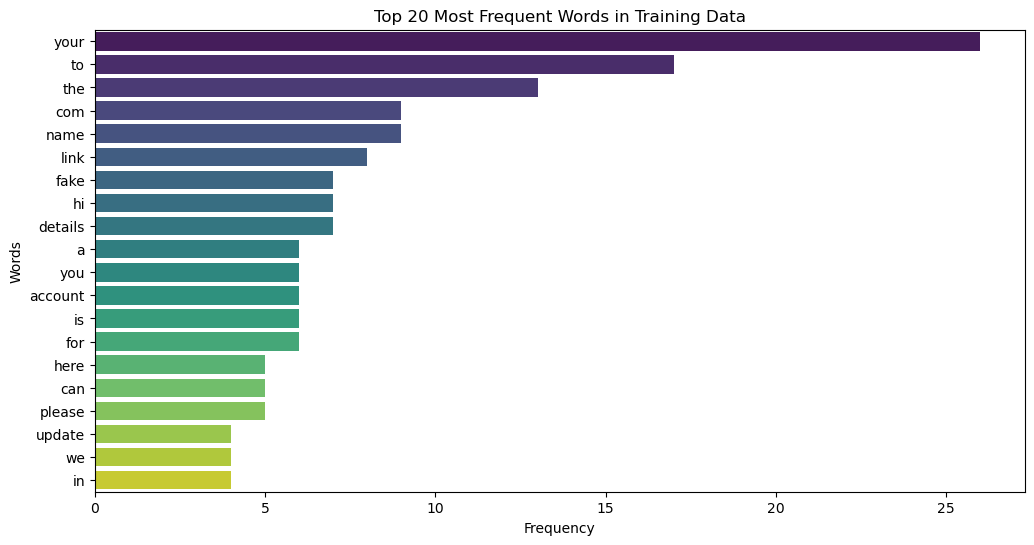

In [12]:
# Visualize the frequency of top words
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:20]
words, counts = zip(*sorted_word_counts)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 20 Most Frequent Words in Training Data")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [13]:
# Pad sequences to ensure equal length
max_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [14]:
# Build the deep learning model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/Users/swigs/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.4737 - loss: 1.0946 - val_accuracy: 0.0000e+00 - val_loss: 1.1198
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4737 - loss: 1.0887 - val_accuracy: 0.0000e+00 - val_loss: 1.1357
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.4211 - loss: 1.0850 - val_accuracy: 0.0000e+00 - val_loss: 1.1568
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.4211 - loss: 1.0795 - val_accuracy: 0.0000e+00 - val_loss: 1.1788
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4211 - loss: 1.0766 - val_accuracy: 0.0000e+00 - val_loss: 1.2028
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4211 - loss: 1.0568 - val_accuracy: 0.0000e+00 - val_loss: 1.2319
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.4211 - loss: 1.0440 - val_accuracy: 0.0000e+00 - val_loss: 1.2671
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.4211 - loss: 1.0545 - val_acc

In [17]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.33


In [18]:
# Generate classification report
y_pred = np.argmax(model.predict(X_test_padded), axis=-1)
classification_report_output = classification_report(y_test, y_pred, target_names=label_encoder.classes_)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


/Users/swigs/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/swigs/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/swigs/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print("\nClassification Report:\n")
print(classification_report_output)



Classification Report:

                precision    recall  f1-score   support

      Phishing       0.33      1.00      0.50         2
    Pretexting       0.00      0.00      0.00         2
Spear Phishing       0.00      0.00      0.00         2

      accuracy                           0.33         6
     macro avg       0.11      0.33      0.17         6
  weighted avg       0.11      0.33      0.17         6



In [20]:
# Visualize training and validation accuracy and loss
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

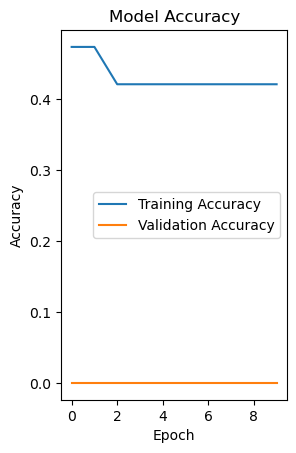

In [21]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

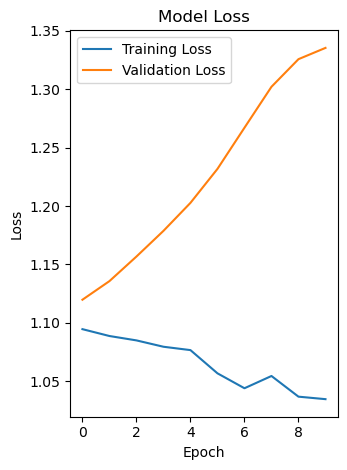

In [22]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Advanced training improvements
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [24]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [25]:
# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

In [26]:
# Retrain the model with advanced callbacks
advanced_history = model.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4211 - loss: 1.0409 - val_accuracy: 0.0000e+00 - val_loss: 1.3268 - learning_rate: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4211 - loss: 1.0260 - val_accuracy: 0.0000e+00 - val_loss: 1.3087 - learning_rate: 0.0010
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4211 - loss: 1.0047 - val_accuracy: 0.0000e+00 - val_loss: 1.2906 - learning_rate: 0.0010
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4211 - loss: 0.9664 - val_accuracy: 0.0000e+00 - val_loss: 1.2867 - learning_rate: 0.0010
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4211 - loss: 0.9699 - val_accuracy: 0.0000e+00 - val_loss: 1.3052 - learning_rate: 0.0010
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4211 - loss: 0.9196 - val_accuracy: 0.0000e+00 - val_loss: 1.3498 - learning_rate: 0.0010
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4211 - loss:

In [27]:
# Visualize advanced training process
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

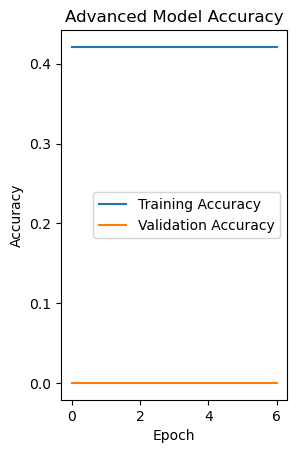

In [28]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(advanced_history.history['accuracy'], label='Training Accuracy')
plt.plot(advanced_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Advanced Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

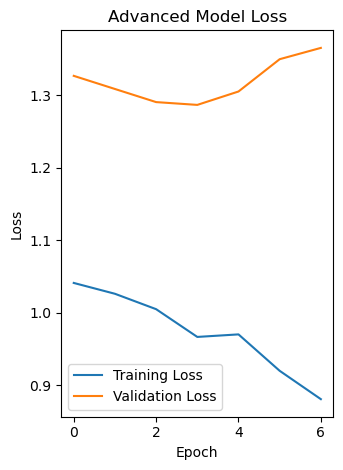

In [29]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(advanced_history.history['loss'], label='Training Loss')
plt.plot(advanced_history.history['val_loss'], label='Validation Loss')
plt.title('Advanced Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
# Advanced reports
print("\nAdvanced Training Evaluation:\n")
final_test_loss, final_test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

final_y_pred = np.argmax(model.predict(X_test_padded), axis=-1)
final_classification_report = classification_report(y_test, final_y_pred, target_names=label_encoder.classes_)

print("\nFinal Classification Report:\n")
print(final_classification_report)



Advanced Training Evaluation:

Final Test Loss: 1.0835
Final Test Accuracy: 0.3333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Final Classification Report:

                precision    recall  f1-score   support

      Phishing       0.33      1.00      0.50         2
    Pretexting       0.00      0.00      0.00         2
Spear Phishing       0.00      0.00      0.00         2

      accuracy                           0.33         6
     macro avg       0.11      0.33      0.17         6
  weighted avg       0.11      0.33      0.17         6



/Users/swigs/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/swigs/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/swigs/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# Test the model using JSON data from URL
def test_model_with_json(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if 'text' in data:
            test_text = data['text']
            test_seq = tokenizer.texts_to_sequences([test_text])
            test_padded = pad_sequences(test_seq, maxlen=max_length, padding='post', truncating='post')
            prediction = np.argmax(model.predict(test_padded), axis=-1)
            predicted_label = label_encoder.inverse_transform(prediction)[0]
            print(f"\nTest Text: {test_text}")
            print(f"Predicted Label: {predicted_label}")
        else:
            print("\nInvalid JSON format: 'text' field is missing.")
    else:
        print(f"\nFailed to fetch data from URL. Status Code: {response.status_code}")

# Example URL for testing
json_url = "https://example.com/test-data.json"
test_model_with_json(json_url)


Failed to fetch data from URL. Status Code: 404


In [32]:
# Save the trained model
model_save_path = "/Users/swigs/Documents/Mmakau/social_engineering_model.keras"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /Users/swigs/Documents/Mmakau/social_engineering_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step

Test Text: We have noticed unusual activity in your FNB account please login using the link below fake.com
Predicted Label: Phishing
Prediction Confidence: 45.84%


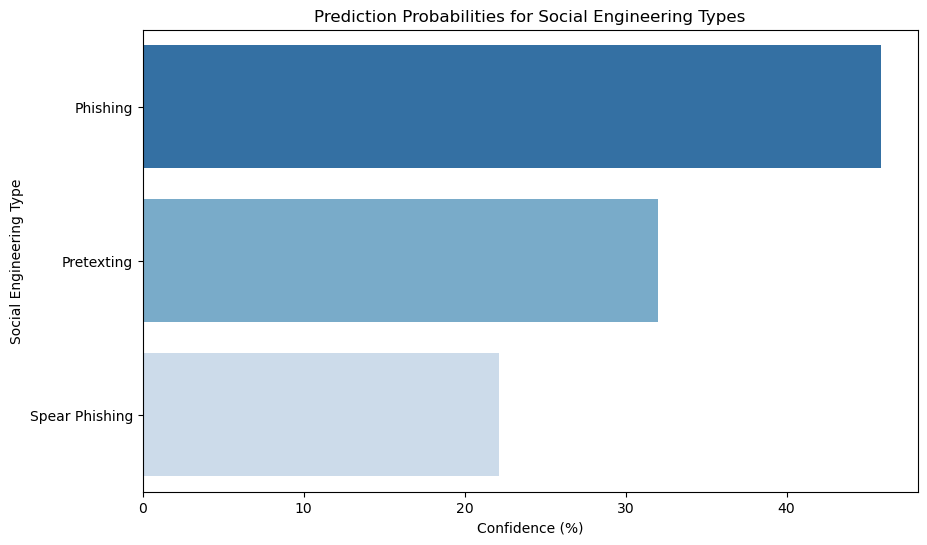

In [33]:
# Save the trained model to determine the type of social engineering attack
test_text = "We have noticed unusual activity in your FNB account please login using the link below fake.com"
test_seq = tokenizer.texts_to_sequences([test_text])
test_padded = pad_sequences(test_seq, maxlen=max_length, padding='post', truncating='post')

# Predict the type of social engineering attack
prediction_probs = model.predict(test_padded)[0]
predicted_label_index = np.argmax(prediction_probs)
predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]
prediction_percentage = prediction_probs[predicted_label_index] * 100

print(f"\nTest Text: {test_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Prediction Confidence: {prediction_percentage:.2f}%")

# Visualize prediction probabilities for all categories
plt.figure(figsize=(10, 6))
sns.barplot(
    x=prediction_probs * 100,
    y=label_encoder.classes_,
    palette="Blues_r"
)
plt.title("Prediction Probabilities for Social Engineering Types")
plt.xlabel("Confidence (%)")
plt.ylabel("Social Engineering Type")
plt.show()


In [35]:
# Load and use the saved model
from tensorflow.keras.models import load_model
if os.path.exists(model_save_path):
    saved_model = load_model(model_save_path)
    saved_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("Model successfully loaded and compiled.")
else:
    print(f"Model file not found at {model_save_path}")


Model successfully loaded and compiled.


In [36]:
# Test a specific example
example_text = "We have noticed unusual activity in your FNB account please login using the link below fake.com"
example_seq = tokenizer.texts_to_sequences([example_text])
example_padded = pad_sequences(example_seq, maxlen=max_length, padding='post', truncating='post')
prediction = np.argmax(saved_model.predict(example_padded), axis=-1)
predicted_label = label_encoder.inverse_transform(prediction)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


In [37]:
# Output the prediction and its percentage
confidence_scores = saved_model.predict(example_padded)[0]
confidence_percentage = confidence_scores[prediction[0]] * 100
print(f"\nExample Text: {example_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Confidence: {confidence_percentage:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Example Text: We have noticed unusual activity in your FNB account please login using the link below fake.com
Predicted Label: Phishing
Confidence: 45.84%


Test Accuracy: 0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Manual Accuracy Score: 0.33


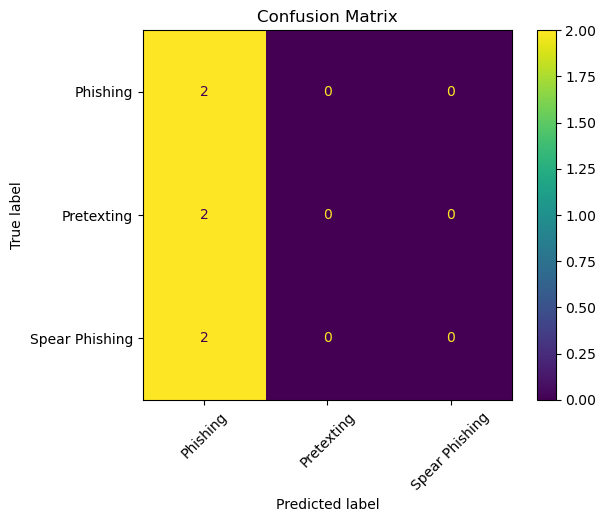

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions
y_pred = np.argmax(model.predict(X_test_padded), axis=-1)

# Calculate accuracy manually
manual_accuracy = accuracy_score(y_test, y_pred)
print(f"Manual Accuracy Score: {manual_accuracy:.2f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='viridis', xticks_rotation=45)

plt.title("Confusion Matrix")
plt.show()


In [39]:
import gensim.downloader as api

# Load pretrained GloVe embeddings
glove_vectors = api.load("glove-wiki-gigaword-100")  # Example: 100-dimensional vectors

# Create embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((10000, embedding_dim))

for word, i in word_index.items():
    if i < 10000:
        embedding_vector = glove_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Replace embedding layer in the model
model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])


[==================================================] 100.0% 128.1/128.1MB downloaded


AttributeError: 'KeyedVectors' object has no attribute 'get'

In [40]:
import gensim.downloader as api
import numpy as np

# Load pretrained GloVe embeddings
glove_vectors = api.load("glove-wiki-gigaword-100")  # Example: 100-dimensional vectors

# Create embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index  # Assumes tokenizer is already created
embedding_matrix = np.zeros((10000, embedding_dim))  # Limit to 10,000 words in vocabulary

for word, i in word_index.items():
    if i < 10000:  # Respect the vocabulary size limit
        if word in glove_vectors:  # Check if word is in pretrained embeddings
            embedding_matrix[i] = glove_vectors[word]

# Replace embedding layer in the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Assumes label_encoder is defined
])

model.summary()


/Users/swigs/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [44]:
# Fetch data from API and train the model
api_url = "https://phishing-url-risk-api.p.rapidapi.com/url/"
querystring = {"url": "appleid.apple.com-sa.pm"}
headers = {
    "x-rapidapi-key": "7561755ecdmsh00fd73d0a965981p149bb9jsn029cedbd0ae4",
    "x-rapidapi-host": "phishing-url-risk-api.p.rapidapi.com"
}

response = requests.get(api_url, headers=headers, params=querystring)

if response.status_code == 200:
    api_data = response.json()
    print("API data successfully fetched.")

    # Assume the API data has 'text' and 'label' fields
    if all(key in api_data for key in ['text', 'label']):
        api_X = api_data['text']
        api_y = label_encoder.transform(api_data['label'])

        # Tokenize and pad the API data
        api_X_seq = tokenizer.texts_to_sequences(api_X)
        api_X_padded = pad_sequences(api_X_seq, maxlen=max_length, padding='post', truncating='post')

        # Evaluate on API data
        api_loss, api_accuracy = model.evaluate(api_X_padded, api_y, verbose=0)
        print(f"API Test Loss: {api_loss:.4f}")
        print(f"API Test Accuracy: {api_accuracy:.4f}")
    else:
        print("The API data format is not compatible.")
else:
    print(f"Failed to fetch data from API. Status Code: {response.status_code}")



Failed to fetch data from API. Status Code: 404


In [45]:
api_url = "https://phishing-url-risk-api.p.rapidapi.com/url/"
querystring = {"url": "appleid.apple.com-sa.pm"}
headers = {
    "x-rapidapi-key": "7561755ecdmsh00fd73d0a965981p149bb9jsn029cedbd0ae4",  # Replace with your actual API key
    "x-rapidapi-host": "phishing-url-risk-api.p.rapidapi.com"
}

response = requests.get(api_url, headers=headers, params=querystring)

if response.status_code == 200:
    api_data = response.json()
    print("API data successfully fetched.")
    print(api_data)
else:
    print(f"Failed to fetch data from API. Status Code: {response.status_code}")
    print("Response Details:", response.text)


Failed to fetch data from API. Status Code: 404
Response Details: <html>
    <head>
        <meta charset="UTF-8">
        <title>Coming Soon: PythonAnywhere</title>
        <style>
            body {
                font-family: Helvetica, Arial, sans-serif;
                width: 500px;
                margin-left: auto;
                margin-right: auto;
                margin-top: 20px;
            }

            h1 {
                font-family: Trebuchet MS, Helvetica, Arial, sans-serif;
            }

            .for-site-owner {
                font-size: smaller;
                margin-top: 30px;
                color: gray;
            }
        </style>
    </head>

    <body>
        <img src="https://s3.amazonaws.com/pythonanywhere-error-images/logo-234x35.png" />

        <div class="main">
            <h1>Coming Soon!</h1>

            <p>
                This is going to be another great website hosted by
                <a href="https://www.pythonanywhere.com/">Pytho